<h1>STEP 1: Import Required Libraries</h1>

In [142]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

<h1> STEP 2: Download Stock Data</h1>

In [143]:
stocks = [ "RELIANCE.NS", "HDFCBANK.NS", "TCS.NS", "INFY.NS", "ICICIBANK.NS", "SBIN.NS", "BHARTIARTL.NS", "BAJFINANCE.NS", "HINDUNILVR.NS", "LT.NS" ]
ticker = "RELIANCE.NS"
data = yf.download(ticker, start="2015-01-01", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


<h1>STEP 3: Fix MultiIndex Issue</h1>

In [144]:
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

<h1>STEP 4: Feature Engineering</h1>

<h3>4.1 Daily Return</h3>

In [145]:
data["Return"] = data["Close"].pct_change()

<h3>4.2 Moving Averages</h3>

In [146]:
data["SMA_5"] = data["Close"].rolling(5).mean()
data["SMA_20"] = data["Close"].rolling(20).mean()
data["EMA_10"] = data["Close"].ewm(span=10).mean()

<h3>4.3 Volatility</h3>

In [147]:
data["Volatility"] = data["Return"].rolling(10).std()

<h3>4.4 Momentum</h3>

In [148]:
data["Momentum"] = data["Close"] - data["Close"].shift(5)

<h3>4.5 Lag Features</h3>

In [149]:
for i in range(1,6):
    data[f"Lag_{i}"] = data["Return"].shift(i)

<h1>STEP 5: Create Target Variable</h1>

In [150]:
data["Target"] = np.where(data["Return"].shift(-1) > 0.01, 1, 0)

<h1>STEP 6: Remove Missing Values</h1>

In [151]:
data.dropna(inplace=True)

<h1>STEP 7: Train/Test Split (Time-Based)</h1>

In [152]:
split = int(len(data) * 0.8)

X = data.drop(columns=["Target"])
y = data["Target"]

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

<h1>STEP 8: Feature Scaling</h1>

In [153]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<h1>STEP 9: LightGBM Model</h1>

In [154]:
model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=1200,
    learning_rate=0.015,
    num_leaves=90,
    max_depth=12,
    min_child_samples=20,
    subsample=0.85,
    colsample_bytree=0.85,
    class_weight="balanced",
    random_state=42
)

<h1>STEP 10: Train Model</h1>

In [155]:
model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 553, number of negative: 1637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2190, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(class_weight='balanced', colsample_bytree=0.85,
               learning_rate=0.015, max_depth=12, n_estimators=1200,
               num_leaves=90, objective='binary', random_state=42,
               subsample=0.85)

<h1>STEP 11: Evaluation</h1>

In [161]:
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", round(accuracy * 100, 2), "%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 80.47 %

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       443
           1       0.25      0.01      0.02       105

    accuracy                           0.80       548
   macro avg       0.53      0.50      0.45       548
weighted avg       0.70      0.80      0.72       548



<h1>STEP 12:Visualization</h1>

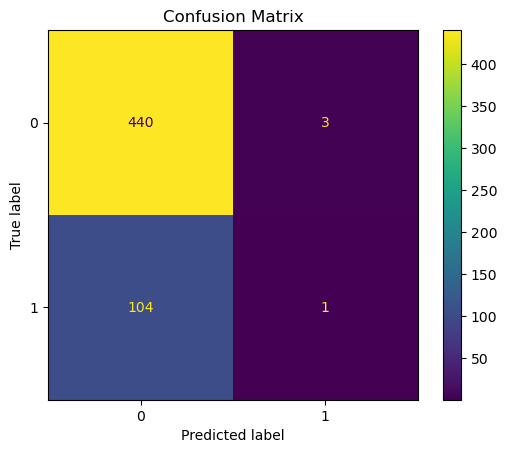

In [157]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

<h1>STEP 13: Save Model & Scaler</h1>

In [160]:
with open(f"{ticker}_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open(f"{ticker}_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open(f"{ticker}_features.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)
print("\nModel, Scaler, and Feature list saved successfully!")


Model, Scaler, and Feature list saved successfully!
